In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

shots_df = pd.read_csv("data/NBA_2004_2024_Shots.csv")
better_shots_df = pd.read_csv("data/shot_logs.csv")

def season_to_df(season):
    return shots_df[shots_df['SEASON_1']==season]

team_name_to_ABB = {
    "Atlanta Hawks":"ATL",
	"Boston Celtics":"BOS",
	"Brooklyn Nets":"BKN",
	"Charlotte Hornets":"CHA",
	"Chicago Bulls":"CHI",
	"Cleveland Cavaliers":"CLE",
	"Dallas Mavericks":"DAL",
	"Denver Nuggets":"DEN",
	"Detroit Pistons":"DET",
    "Golden State Warriors":"GSW",
	"Houston Rockets":"HOU",
	"Indiana Pacers":"IND",
	"Los Angeles Clippers":"LAC",
	"Los Angeles Lakers":"LAL",
	"Memphis Grizzlies":"MEM",
	"Miami Heat":"MIA",
	"Milwaukee Bucks":"MIL",
	"Minnesota Timberwolves":"MIN",
    "New Orleans Pelicans":"NOP",
    "New York Knicks":"NYK",
	"Oklahoma City Thunder":"OKC",
	"Orlando Magic":"ORL",
	"Philadelphia 76ers":"PHI",
	"Phoenix Suns":"PHX",
	"Portland Trail Blazers":"PHX",
	"Sacramento Kings":"SAC",
    "San Antonio Spurs":"SAS",
	"Toronto Raptors":"TOR",
    "Utah Jazz":"UTA",
	"Washington Wizards":"WAS"
}

class MakeDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values,dtype=torch.float32)
        self.labels = torch.tensor(labels.values,dtype=torch.float32)
        
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [8]:
category_sizes = []
label_to_one_hot = ["ACTION_TYPE","BASIC_ZONE","ZONE_NAME"]

for categorical_var in label_to_one_hot:
    category_sizes.append(range(shots_df[categorical_var].unique().shape[0]))

def shots_data_processing(df):
    #select columns, label encoding
    df_condensed = df[["PLAYER_ID","HOME_TEAM","ACTION_TYPE","SHOT_TYPE","BASIC_ZONE","ZONE_NAME","LOC_X","LOC_Y","SHOT_DISTANCE","QUARTER"]]
    df_outcome = df["SHOT_MADE"]
    df_condensed.loc[:,"HOME_TEAM"] = (df["TEAM_NAME"].map(team_name_to_ABB)==df["HOME_TEAM"])
    df_condensed.loc[:,"TIME_LEFT"] = (df["MINS_LEFT"]*60+df["SECS_LEFT"])
    df_condensed["HOME_TEAM"] = df_condensed["HOME_TEAM"].astype(int)
    for category in df_condensed.keys():
        if not (df_condensed[category].dtype in [int,float]):
            tmp_dict = {k:i for i,k in enumerate(sorted(df[category].unique()))}
            df_condensed.loc[:,category] = df_condensed[category].map(tmp_dict)

    #label encoding -> one-hot encoding
    encoder = OneHotEncoder(categories=category_sizes,sparse_output=False, dtype="float32",handle_unknown='error')
    one_hot_encoded = encoder.fit_transform(df_condensed[label_to_one_hot])
    encoded_df = pd.DataFrame(
        one_hot_encoded,
        columns=encoder.get_feature_names_out(label_to_one_hot),
        index=df.index
    )
    df_condensed = pd.concat([df_condensed.drop(columns=label_to_one_hot), encoded_df], axis=1)

    #temp drop
    df_condensed_drop = df_condensed.drop(columns=["PLAYER_ID"])

    #scaling to [-1,1]
    def scaling_func(x):
        if not (x.max() == 1 and x.min() == 0):
            return 2 * (x - x.min()) / (x.max() - x.min()) - 1
        return x
    df_condensed_drop_scaled = df_condensed_drop.apply(scaling_func).astype("float32")

    df_condensed_drop_scaled = df_condensed_drop_scaled.fillna(0)

    return MakeDataset(df_condensed_drop_scaled,df_outcome)

In [9]:
# processed_train_data = shots_data_processing(shots_df.sample(200000))
processed_train_data = shots_data_processing(season_to_df(2024))
processed_test_data = [shots_data_processing(season_to_df(season)) for season in range(2004,2024+1)]

batch_size = 32

trainloader = DataLoader(processed_train_data,batch_size=batch_size,shuffle=False)
testloaders = [DataLoader(x,batch_size=batch_size,shuffle=False) for x in processed_test_data]

/var/folders/y0/sc7jmx7n2vs9kmrjt2zyfpk00000gn/T/ipykernel_50903/3195145373.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condensed.loc[:,"TIME_LEFT"] = (df["MINS_LEFT"]*60+df["SECS_LEFT"])
/var/folders/y0/sc7jmx7n2vs9kmrjt2zyfpk00000gn/T/ipykernel_50903/3195145373.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_condensed["HOME_TEAM"] = df_condensed["HOME_TEAM"].astype(int)
/var/folders/y0/sc7jmx7n2vs9kmrjt2zyfpk00000gn/T/ipykernel_50903/3195145373.py:6: SettingWithCopyWarning: 
A value is t

In [29]:
class LogRegModel(nn.Module):
    def __init__(self,input_size):
        super(LogRegModel,self).__init__()
        self.fc1 = nn.Linear(input_size,1)
    def forward(self,x):
        f1 = self.fc1(x)
        return f1

In [15]:
class nnModel(nn.Module):
    def __init__(self,input_size,hidden_layer_size):
        super(nnModel,self).__init__()
        self.fc1 = nn.Linear(input_size,hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size,1)
        self.relu = nn.LeakyReLU(negative_slope=0.01, inplace=False)
        self._initialize_weights()
    def forward(self,x):
        f1 = self.relu(self.fc1(x))
        f2 = self.fc2(f1)
        return f2
    def _initialize_weights(self):
        # Apply He initialization to all layers with ReLU/LeakyReLU activations
        nn.init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='leaky_relu')
        nn.init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='leaky_relu')

        # Bias initialization (optional but recommended)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

In [48]:
model = LogRegModel(processed_train_data[0][0].shape[0])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
num_epochs = 1
loss_values = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(-1), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # print statistics
        if i % 1000 == 999:    # print every n mini-batches
            loss_values.append(running_loss/1000)
            running_loss = 0.0
    # total_norm = 0
    # for param in model.parameters():
    #     if param.grad is not None:
    #         param_norm = param.grad.data.norm(2)
    #         total_norm += param_norm.item() ** 2
    # total_norm = total_norm ** 0.5
    # print(f"Epoch {epoch+1}, Loss: {running_loss / i:.3f}, Gradient Norm: {total_norm}")
    # # Calculate average loss for the epoch
    # avg_loss = running_loss / i
    # # Store the average loss
    # loss_values.append(avg_loss)

print('Finished Training')

6835it [00:05, 1361.18it/s]

Finished Training


I experimented with up to 10 epochs, but observed the loss either stagnates or decreases slowly. In addition, even if the loss decreased, the accuracy of the model didn't seem to increase. I suspect this is due to overfitting.

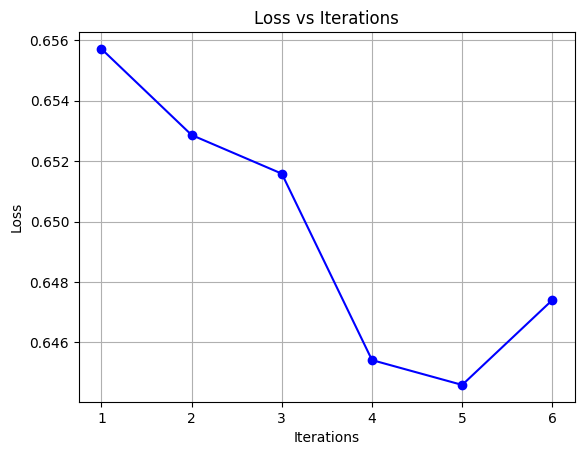

In [50]:
# Plotting the loss
# plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='b')
plt.plot(range(1, (len(trainloader)//1000)*num_epochs+1), loss_values, marker='o', color='b')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs Iterations')
plt.grid(True)
plt.show()

In [35]:
correct, total = 0, 0
test_acc = []
with torch.no_grad():
    for testloader in tqdm(testloaders):
        correct, total = 0, 0
        for data in testloader:
            features, outcome = data
            outputs = model(features)  # Raw logits
            predicted = (outputs.squeeze(-1) > 0).int()  # Threshold logits at 0
            total += outcome.size(0)
            correct += (predicted == outcome).sum().item()
        test_acc.append(correct / total)  # Accuracy

100%|██████████| 21/21 [00:30<00:00,  1.46s/it]


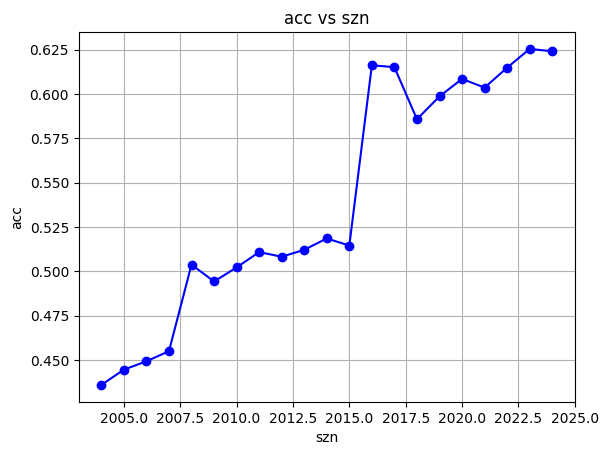

In [36]:
# Plotting the loss
# plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='b')
plt.plot(range(2004, 2004+len(testloaders)), test_acc, marker='o', color='b')
plt.xlabel('szn')
plt.ylabel('acc')
plt.title('acc vs szn')
plt.grid(True)
plt.show()

What's really interesting is that a model trained on data from the 2024 season will perform worse the further back in time you go. It's unclear why this is but I suspect it's due to the shift in the types of shots taken in the NBA (e.g. more 3 pointers are taken around 2015). 

In [42]:
acc = []

for hidden_layer_size in tqdm(range(1,65)):
    model = nnModel(processed_train_data[0][0].shape[0],hidden_layer_size)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 1
    loss_values = []
    running_loss = 0.0

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(-1), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
    acc.append(running_loss/len(trainloader))

100%|██████████| 64/64 [05:34<00:00,  5.23s/it]


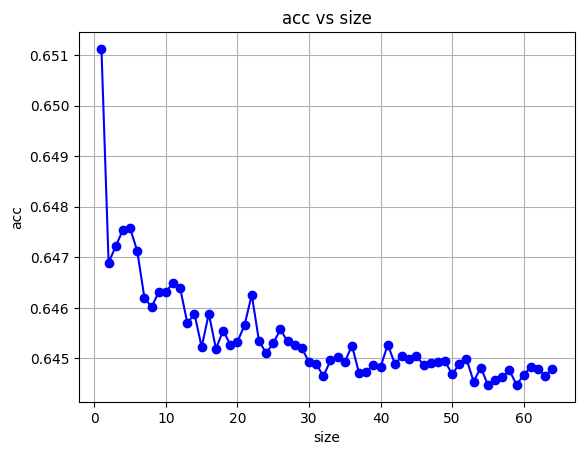

In [43]:
# Plotting the loss
# plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='b')
plt.plot(range(1,65), acc, marker='o', color='b')
plt.xlabel('size')
plt.ylabel('acc')
plt.title('acc vs size')
plt.grid(True)
plt.show()

This graph seems to show that a more complex neural network does not outperform the simple logistic regression model. In fact, more complicated neural nets seem to overfit to the training data and perform worse --  though the difference in accuracy does not seem to be great. 

In [106]:
def print_weight_and_gradient_magnitudes(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Print the name of the parameter
            print(f"Layer: {name}")

            # Magnitude of the weights
            weight_magnitude = torch.norm(param.data)  # Using L2 norm (Euclidean norm)
            print(f"Weight Magnitude: {weight_magnitude.item()}")

            # Magnitude of the gradients (only after backward pass)
            if param.grad is not None:
                gradient_magnitude = torch.norm(param.grad)  # L2 norm of the gradients
                print(f"Gradient Magnitude: {gradient_magnitude.item()}")
            else:
                print("No gradients available yet")

            print("-" * 40)
print_weight_and_gradient_magnitudes(model)

Layer: fc1.weight
Weight Magnitude: 10.919662475585938
Gradient Magnitude: 0.4815187454223633
----------------------------------------
Layer: fc1.bias
Weight Magnitude: 0.585003674030304
Gradient Magnitude: 0.17894427478313446
----------------------------------------
Layer: fc2.weight
Weight Magnitude: 1.397157907485962
Gradient Magnitude: 0.2587103545665741
----------------------------------------
Layer: fc2.bias
Weight Magnitude: 0.11413516849279404
Gradient Magnitude: 0.017105557024478912
----------------------------------------


Epoch 1, Loss: 0.6279956638813019
Epoch 2, Loss: 0.6272502660751342
Epoch 3, Loss: 0.6258918404579162
Epoch 4, Loss: 0.6244385659694671
Epoch 5, Loss: 0.6230570614337921
Epoch 6, Loss: 0.6217852830886841
Epoch 7, Loss: 0.6206193327903747
Epoch 8, Loss: 0.6195445358753204
Epoch 9, Loss: 0.6185455918312073
Epoch 10, Loss: 0.6176093518733978
Epoch 11, Loss: 0.6167252361774445
Epoch 12, Loss: 0.6158849954605102
Epoch 13, Loss: 0.6150822818279267
Epoch 14, Loss: 0.6143119215965271
Epoch 15, Loss: 0.6135700941085815
Epoch 16, Loss: 0.612853616476059
Epoch 17, Loss: 0.6121600270271301
Epoch 18, Loss: 0.6114872753620147
Epoch 19, Loss: 0.6108337342739105
Epoch 20, Loss: 0.6101979434490203
Epoch 21, Loss: 0.6095787882804871
Epoch 22, Loss: 0.6089752018451691
Epoch 23, Loss: 0.6083863914012909
Epoch 24, Loss: 0.6078115165233612
Epoch 25, Loss: 0.6072499215602875
Epoch 26, Loss: 0.6067009806632996
Epoch 27, Loss: 0.606164139509201
Epoch 28, Loss: 0.6056388735771179
Epoch 29, Loss: 0.6051247477531

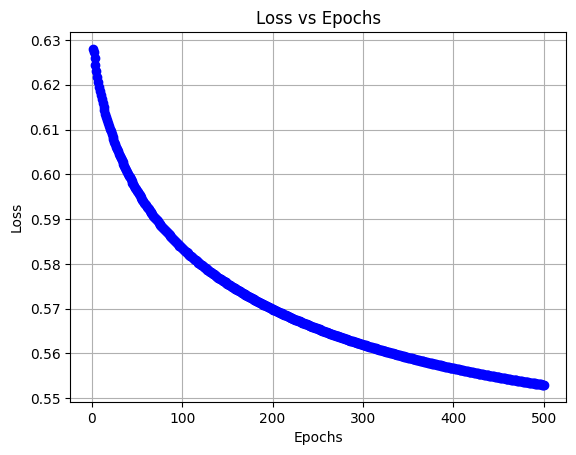

In [18]:
import matplotlib.pyplot as plt
from itertools import islice

batch_size = 32

small_dataloader = DataLoader(processed_train_data[:10],batch_size=batch_size,shuffle=False)

# List to store loss values for each epoch
loss_values = []
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for data in islice(trainloader,0,10):
        inputs,labels = data
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(-1), labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimizer step
        running_loss += loss.item()  # Add loss for this batch
    
    # Calculate average loss for the epoch
    avg_loss = running_loss / 10
    
    # Store the average loss
    loss_values.append(avg_loss)
    
    print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

# Plotting the loss
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.grid(True)
plt.show()